In [1]:
import os
# Deshabilita la GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

# Suprime los logs de TensorFlow relacionados con errores e información
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  

# Suprime las advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Importa TensorFlow y Keras
import tensorflow as tf
import keras

# Imprime las versiones de TensorFlow y Keras instaladas en el entorno
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

E0000 00:00:1732731312.768504    6187 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732731312.773509    6187 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Keras version: 3.6.0


In [2]:
# Importación de módulos estándar
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importación de módulos de Keras para construcción de modelos de redes neuronales
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Conv1D, MaxPooling1D, UpSampling1D, Reshape
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras import metrics


# Importación de módulos de scikit-learn para preprocesamiento y evaluación de modelos
from sklearn.metrics import (classification_report, confusion_matrix,mean_squared_error, recall_score, precision_score, 
                             accuracy_score, f1_score, roc_auc_score)
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Importación del módulo time para medir tiempos de ejecución
from time import time

# Configuración de semillas aleatorias para reproducibilidad
np.random.seed(7)
seed = 15
rng = np.random.RandomState(313)

# Configuración para visualizar gráficos en línea en Jupyter Notebook
%matplotlib inline



## Carga y Exploración de los Datos

En esta sección, cargamos los conjuntos de datos balanceados para entrenamiento y prueba, exploramos su composición y preparamos las características (`X`) y las etiquetas (`Y`) para el modelado.

#### Resultados Observados

1. **Conjunto de Entrenamiento (Autoencoder)**:
   - Cantidad de observaciones por clase:
     - Clase `0` (sanos): 6,212 (50.06%)
     - Clase `1` (afectados): 6,196 (49.94%)
   - Dimensiones:
     - Características: (12,408 observaciones, 606 columnas)
     - Etiquetas: (12,408 observaciones)

2. **Conjunto de Prueba para Autoencoder (AE)**:
   - Cantidad de observaciones por clase:
     - Clase `0` (sanos): 777 (50.10%)
     - Clase `1` (afectados): 774 (49.90%)
   - Dimensiones:
     - Características: (1,551 observaciones, 606 columnas)
     - Etiquetas: (1,551 observaciones)

In [3]:
X_train_ae = pd.read_csv(r"../Datos/BinarioTrainBalanced.csv")
X_test_ae  = pd.read_csv(r"../Datos/BinarioTest1Balanced.csv")

In [4]:
print("\n\t\tDatos de entrenamiento")
nr_clases = X_train_ae['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_train_ae.shape[0])
Y_train_ae = X_train_ae['CLASS_LABEL']
X_train_ae = X_train_ae.drop(['CLASS_LABEL'], axis=1)
print(X_train_ae.shape, Y_train_ae.shape)

print("\n\t\tDatos de prueba AE")
nr_clases = X_test_ae['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_test_ae.shape[0])
Y_test_ae = X_test_ae['CLASS_LABEL']
X_test_ae = X_test_ae.drop(['CLASS_LABEL'], axis=1)
print(X_test_ae.shape, Y_test_ae.shape)


		Datos de entrenamiento

Cantidad  CLASS_LABEL
0    6212
1    6196
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.064475
1    49.935525
Name: count, dtype: float64
(12408, 606) (12408,)

		Datos de prueba AE

Cantidad  CLASS_LABEL
0    777
1    774
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.096712
1    49.903288
Name: count, dtype: float64
(1551, 606) (1551,)


## Cambio de tamaño de los datos
El cambio de tamaño del conjunto de datos `X_train` y `X_test` a través de `reshape` es necesario debido al uso de una red neuronal convolucional 1D (`Conv1D`) en este modelo. Las redes convolucionales 1D requieren que los datos de entrada tengan una forma específica para procesar correctamente las características:

1. **Forma original de los datos**:
   - `X_train` y `X_test` se cargan inicialmente como DataFrames o matrices 2D de forma `(n_samples, n_features)`, donde:
     - `n_samples` es el número de muestras.
     - `n_features` es el número de características por muestra.

2. **Requerimiento de las capas `Conv1D`**:
   - Las capas convolucionales 1D esperan que los datos de entrada tengan una forma tridimensional de `(n_samples, time_steps, n_channels)`, donde:
     - `time_steps` corresponde al número de características o pasos temporales de cada muestra.
     - `n_channels` es el número de canales (generalmente 1 para datos univariantes).

3. **Transformación realizada**:
   ```python
   X_train = X_train.to_numpy().reshape((X_train.shape[0], X_train.shape[1], 1))
   X_test = X_test.to_numpy().reshape((X_test.shape[0], X_test.shape[1], 1))


### Justificación práctica

#### Compatibilidad
Sin esta transformación, el modelo arrojaría un error, ya que la capa `Conv1D` no puede procesar entradas de dimensión 2D (`(n_samples, n_features)`).

#### Flexibilidad
La forma `(n_samples, time_steps, n_channels)` también permite incorporar más canales en el futuro si se añaden características adicionales o representaciones multivariantes.



In [5]:
X_train = X_train_ae.to_numpy().reshape((X_train_ae.shape[0], X_train_ae.shape[1], 1))
X_test = X_test_ae.to_numpy().reshape((X_test_ae.shape[0], X_test_ae.shape[1], 1))

# Verificar las dimensiones de las entradas redimensionadas
print("Dimensión de X_train después de redimensionar:", X_train.shape)
print("Dimensión de X_test después de redimensionar:", X_test.shape)

Dimensión de X_train después de redimensionar: (12408, 606, 1)
Dimensión de X_test después de redimensionar: (1551, 606, 1)


## Crear Autoencoder CNN 1D y Búsqueda de Hiperparámetros

En esta sección, se define un autoencoder convolucional 1D utilizando Keras y se emplea la biblioteca Keras Tuner para buscar automáticamente los hiperparámetros óptimos del modelo.

### Pasos del Código

1. **Definición del Modelo**:
   - El modelo se define dentro de la función `build_model(hp)`, que utiliza Keras Tuner para ajustar hiperparámetros.
   - Arquitectura del autoencoder:
     - **Encoder**:
       - Entrada con forma `(606, 1)` para manejar datos 1D.
       - Dos capas convolucionales 1D (`Conv1D`) con hiperparámetros ajustables:
         - `encoder_filters1` y `encoder_filters2`: Número de filtros (entre 32 y 96, con pasos de 32).
         - `kernel_size1` y `kernel_size2`: Tamaño del kernel (3 o 5).
       - Capas de submuestreo (`MaxPooling1D`) para reducir dimensionalidad.
     - **Latente**:
       - Capa de aplanamiento (`Flatten`) para preparar datos.
       - Capa densa (`Dense`) con dimensión del espacio latente ajustable:
         - `latent_dim`: Entre 50 y 100, con pasos de 10.
     - **Decoder**:
       - Reconstrucción simétrica al encoder con capas `Dense`, `Reshape`, y `UpSampling1D`.
       - Ajuste de dimensiones con una capa convolucional final (`Conv1D`) y `ZeroPadding1D` para garantizar que la salida coincida con la entrada.

2. **Compilación del Modelo**:
   - Optimizador: Adam con tasa de aprendizaje ajustable (`learning_rate`):
     - Posibles valores: 0.01, 0.001 o 0.0001.
   - Función de pérdida: `MeanSquaredError` para medir la reconstrucción.
   - Métricas:
     - Error cuadrático medio (`mse`).
     - Error absoluto medio (`mae`).
     - Coeficiente de determinación (`r2_score`).

3. **Búsqueda de Hiperparámetros**:
   - Configuración con `HyperBand`:
     - Permite explorar configuraciones prometedoras asignando recursos adaptativamente.
     - Métrica objetivo: Minimizar el `val_mse`.
     - Configuración:
       - `max_epochs=50`: Máximo de 50 épocas por modelo.
       - `factor=3`: Reducción progresiva de configuraciones no prometedoras.
       - Directorio de trabajo: `autoencoder_tuner_cnn1d`.
       - Proyecto: `autoencoder_tuner_cnn1d`.
   - Ejecución del método `tuner.search`:
     - Entrena el autoencoder en el conjunto de entrenamiento (`X_train`).
     - Reserva el 20% de los datos de entrenamiento para validación.


### Resultados Esperados
- **Autoencoder óptimo**: Configuración seleccionada para minimizar el error cuadrático medio en validación.
- **Arquitectura ajustada**:
  - Número óptimo de filtros y tamaños de kernel en el encoder.
  - Dimensión óptima del espacio latente.
  - Tasa de aprendizaje que favorezca la convergencia del modelo.
- **Métricas de evaluación**: Comparación de las predicciones reconstruidas con los datos originales.

In [6]:
from tensorflow.keras import backend as K

def r2_score(y_true, y_pred):
    # Asegurarse de que las dimensiones sean consistentes
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())


In [7]:
def build_model(hp):
    # Asegurarse de que time_steps esté definido correctamente
    time_steps = X_train.shape[1]
    input_channels = X_train.shape[2]

    # Entrada del autoencoder
    input_layer = Input(shape=(time_steps, input_channels))

    # Construcción del encoder
    x = input_layer
    encoder_filters = []
    encoder_kernels = []

    for i in range(1, 3):
        filters = hp.Int(f'encoder_filters{i}', min_value=32, max_value=96, step=32)
        kernel_size = hp.Choice(f'kernel_size{i}', values=[3, 5])
        encoder_filters.append(filters)
        encoder_kernels.append(kernel_size)
        x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = MaxPooling1D(pool_size=2, padding='same')(x)

    # Aplanar y pasar al espacio latente denso
    x = Flatten()(x)
    latent_dim = hp.Int('latent_dim', min_value=50, max_value=100, step=10)
    latent_space = Dense(latent_dim, activation='relu')(x)

    # Construcción del decoder
    x = Dense((time_steps // (2**len(encoder_filters))) * encoder_filters[-1], activation='relu')(latent_space)
    x = Reshape((time_steps // (2**len(encoder_filters)), encoder_filters[-1]))(x)

    for filters, kernel_size in zip(reversed(encoder_filters), reversed(encoder_kernels)):
        x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = UpSampling1D(size=2)(x)

    # Ajustar la dimensión de salida al tamaño de entrada
    x = Conv1D(filters=input_channels, kernel_size=1, activation='linear', padding='same')(x)

    # Rellenar para restaurar dimensiones exactas
    output_layer = tf.keras.layers.ZeroPadding1D(padding=((1, 1)))(x)

    # Definir el modelo completo
    autoencoder = Model(inputs=input_layer, outputs=output_layer)

    # Compilar el modelo
    autoencoder.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss=MeanSquaredError(),
        metrics=['mse', 'mae', r2_score]
    )

    return autoencoder



In [8]:
# Configuración de Keras Tuner para la búsqueda
import kerastuner as kt

tuner = kt.Hyperband(
    build_model,  # Modelo definido anteriormente
    objective='val_mse',  # Métrica objetivo para optimizar
    max_epochs=50,  # Máximo de épocas por modelo
    factor=3,  # Factor de reducción de Hyperband
    directory='autoencoder_tuner_cnn1d',  # Directorio para guardar resultados
    project_name='autoencoder_tuner_cnn1d'  # Nombre del proyecto
)


Reloading Tuner from autoencoder_tuner_cnn1d/autoencoder_tuner_cnn1d/tuner0.json


In [9]:
# Realizar la búsqueda de hiperparámetros
tuner.search(
    X_train, X_train,
    epochs=50,
    validation_split=0.2,
    batch_size=128,
    verbose=1
)

### Resultados de la Búsqueda de Hiperparámetros y Modelo Óptimo

En esta sección, se presentan los resultados obtenidos tras la búsqueda de hiperparámetros utilizando Keras Tuner y un resumen de la arquitectura del mejor modelo seleccionado.


#### Resultados de la Búsqueda
- **Duración Total**: Aproximadamente 2 horas y 30 minutos.
- **Mejor Error Cuadrático Medio en Validación (val_mse)**: `0.00020566` (Trial 0085).
- **Número Total de Pruebas**: 89.

Los 10 mejores ensayos y sus hiperparámetros asociados:

| Trial ID | `filters1` | `kernel1` | `filters2` | `kernel2` | `latent_dim` | `learning_rate` | val_mse          |
|----------|---------------------|----------------|---------------------|----------------|--------------|-----------------|------------------|
| 0085     | 96                  | 5              | 64                  | 3              | 100          | 0.001           | 0.00020566       |
| 0051     | 32                  | 3              | 64                  | 5              | 90           | 0.001           | 0.00022442       |
| 0082     | 64                  | 5              | 96                  | 3              | 60           | 0.001           | 0.00023470       |
| 0050     | 96                  | 5              | 32                  | 3              | 80           | 0.001           | 0.00023523       |
| 0088     | 64                  | 5              | 64                  | 5              | 80           | 0.0001          | 0.00024436       |
| 0087     | 32                  | 3              | 64                  | 3              | 50           | 0.001           | 0.00025159       |
| 0073     | 64                  | 3              | 96                  | 3              | 100          | 0.001           | 0.00025307       |
| 0072     | 64                  | 3              | 96                  | 3              | 80           | 0.001           | 0.00025723       |
| 0086     | 96                  | 3              | 32                  | 3              | 60           | 0.001           | 0.00027823       |
| 0084     | 96                  | 3              | 64                  | 3              | 70           | 0.001           | 0.00028016       |


#### Arquitectura del Mejor Modelo
El mejor modelo seleccionado corresponde al Trial 0085. Su arquitectura es la siguiente:

| Capa               | Tipo             | Forma de Salida       | Parámetros | Hiperparámetros                     |
|--------------------|------------------|-----------------------|------------|-------------------------------------|
| `input_layer`      | InputLayer       | (None, 606, 1)        | 0          | -                                   |
| `conv1d`           | Conv1D          | (None, 606, 96)       | 576        | `filters`: 96, `kernel`: 5          |
| `max_pooling1d`    | MaxPooling1D    | (None, 303, 96)       | 0          | -                                   |
| `conv1d_1`         | Conv1D          | (None, 303, 64)       | 18,496     | `filters`: 64, `kernel`: 3          |
| `max_pooling1d_1`  | MaxPooling1D    | (None, 152, 64)       | 0          | -                                   |
| `flatten`          | Flatten         | (None, 9728)          | 0          | -                                   |
| `dense`            | Dense           | (None, 100)           | 972,900    | `units`: 100                        |
| `dense_1`          | Dense           | (None, 9664)          | 976,064    | -                                   |
| `reshape`          | Reshape         | (None, 151, 64)       | 0          | -                                   |
| `conv1d_2`         | Conv1D          | (None, 151, 64)       | 12,352     | `filters`: 64, `kernel`: 3          |
| `up_sampling1d`    | UpSampling1D    | (None, 302, 64)       | 0          | -                                   |
| `conv1d_3`         | Conv1D          | (None, 302, 96)       | 30,816     | `filters`: 96, `kernel`: 5          |
| `up_sampling1d_1`  | UpSampling1D    | (None, 604, 96)       | 0          | -                                   |
| `conv1d_4`         | Conv1D          | (None, 604, 1)        | 97         | -                                   |
| `zero_padding1d`   | ZeroPadding1D   | (None, 606, 1)        | 0          | -                                   |

- **Total de Parámetros**: 2,011,301.
  - Parámetros Entrenables: 2,011,301.
  - Parámetros No Entrenables: 0.

### Arquitectura del Modelo

| Tipo               | Forma de Salida     | Parámetros |
|--------------------|---------------------|------------|
| InputLayer         | (None, 606, 1)     | 0          |
| Conv1D             | (None, 606, 96)    | 576        |
| MaxPooling1D       | (None, 303, 96)    | 0          |
| Conv1D             | (None, 303, 64)    | 18,496     |
| MaxPooling1D       | (None, 152, 64)    | 0          |
| Flatten            | (None, 9728)       | 0          |
| Dense              | (None, 100)        | 972,900    |
| Dense              | (None, 9664)       | 976,064    |
| Reshape            | (None, 151, 64)    | 0          |
| Conv1D             | (None, 151, 64)    | 12,352     |
| UpSampling1D       | (None, 302, 64)    | 0          |
| Conv1D             | (None, 302, 96)    | 30,816     |
| UpSampling1D       | (None, 604, 96)    | 0          |
| Conv1D             | (None, 604, 1)     | 97         |
| ZeroPadding1D      | (None, 606, 1)     | 0          |



#### Comentarios
1. **Desempeño del Modelo**:
   - El modelo alcanzó un error cuadrático medio en validación (val_mse) de `0.00020566`, indicando una alta precisión en la reconstrucción.
2. **Arquitectura Balanceada**:
   - El encoder y el decoder son simétricos, lo que asegura una representación eficiente y precisa en el espacio latente.
   - El uso de `ZeroPadding1D` garantiza que las dimensiones de salida coincidan exactamente con las de entrada.
3. **Eficiencia del Tuner**:
   - Keras Tuner exploró diversas combinaciones de hiperparámetros, maximizando el rendimiento del autoencoder de manera eficiente.

Este modelo óptimo está listo para ser utilizado en tareas de compresión, reconstrucción de datos o como extractor de características.


In [10]:
# Resumen de los mejores modelos
tuner.results_summary()

Results summary
Results in autoencoder_tuner_cnn1d/autoencoder_tuner_cnn1d
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 0085 summary
Hyperparameters:
encoder_filters1: 96
kernel_size1: 5
encoder_filters2: 64
kernel_size2: 3
latent_dim: 100
learning_rate: 0.001
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.00020566186867654324

Trial 0051 summary
Hyperparameters:
encoder_filters1: 32
kernel_size1: 3
encoder_filters2: 64
kernel_size2: 5
latent_dim: 90
learning_rate: 0.001
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0049
Score: 0.00022442013141699135

Trial 0082 summary
Hyperparameters:
encoder_filters1: 64
kernel_size1: 5
encoder_filters2: 96
kernel_size2: 3
latent_dim: 60
learning_rate: 0.001
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0074
Score: 0.00023470241285394877

Trial 0050 summary
Hyperparameters:
encoder_filters1: 96
kernel_si

In [11]:
# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=2)[0]

# Mostrar el resumen del segundo mejor modelo
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 606, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 606, 96)        │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 303, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 303, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 152, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       972,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9664)           │       976,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 151, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 151, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 302, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 302, 96)        │        30,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 604, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 604, 1)         │            97 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d (ZeroPadding1D)  │ (None, 606, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,011,301 (7.67 MB)

 Trainable params: 2,011,301 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

### Evaluación del Modelo Óptimo

Se evalúa el rendimiento del modelo óptimo (seleccionado por Keras Tuner) en los conjuntos de entrenamiento, validación y prueba, para medir su precisión en la reconstrucción y capacidad de generalización.


#### Resumen de Desempeño
| Métrica               | Entrenamiento      | Validación        | Prueba            |
|-----------------------|--------------------|-------------------|-------------------|
| **`MSE`** | 0.000206  | 0.000206          | 0.000208          |
| **`MAE`)**   | 0.009519          | 0.009521          | 0.009567          |
| **`R2 Score`**   | 0.998776          | 0.998774          | 0.998768          |


#### Observaciones
1. **Rendimiento en Validación**:
   - Las métricas en el conjunto de validación son prácticamente idénticas a las del entrenamiento, lo que indica que el modelo tiene un excelente ajuste y no presenta signos de sobreajuste significativo.

2. **Diferencia en Prueba**:
   - Las métricas del conjunto de prueba son ligeramente inferiores a las de entrenamiento y validación. Esto es esperable y refleja que el modelo mantiene una generalización adecuada.

3. **Error Cuadrático Medio (MSE)**:
   - El MSE extremadamente bajo (cerca de 0.0002 en todos los conjuntos) indica que el modelo reconstruye las entradas de manera precisa.

4. **Error Absoluto Medio (MAE)**:
   - Los valores bajos de MAE (~0.0095) confirman la alta precisión en la reconstrucción de las señales.

5. **R² (Coeficiente de Determinación)**:
   - Un R² superior a 0.998 en todos los conjuntos de datos indica que el modelo captura casi la totalidad de la variabilidad en los datos, lo que lo hace altamente confiable.


In [12]:
# Definir las métricas configuradas en el modelo
metricas = ['Loss', 'Mean Squared Error', 'Mean Absolute Error', 'R2 Score']

# Evaluar el modelo en el conjunto de entrenamiento
train_metrics = best_model.evaluate(X_train, X_train, verbose=0)

# Mostrar las métricas
print("\nMétricas del Autoencoder en el Conjunto de Entrenamiento:")
print("-" * 50)
for nombre, valor in zip(metricas, train_metrics):
    print(f"{nombre}: {valor:.6f}")



Métricas del Autoencoder en el Conjunto de Entrenamiento:
--------------------------------------------------
Loss: 0.000206
Mean Squared Error: 0.000206
Mean Absolute Error: 0.009519
R2 Score: 0.998776


In [13]:
# Obtener las métricas de validación del mejor ensayo durante la búsqueda
print("\nMétricas del Mejor Modelo en Validación durante la Búsqueda:")
print("-" * 50)
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]  # Mejor ensayo
for metric_name in best_trial.metrics.metrics.keys():
    if "val_" in metric_name:  # Filtrar solo métricas de validación
        val_metric = best_trial.metrics.get_last_value(metric_name)
        print(f"{metric_name}: {val_metric:.6f}")


Métricas del Mejor Modelo en Validación durante la Búsqueda:
--------------------------------------------------
val_loss: 0.000206
val_mae: 0.009521
val_mse: 0.000206
val_r2_score: 0.998774


In [14]:
# Evaluar el autoencoder en el conjunto de prueba
test = best_model.evaluate(X_test, X_test, verbose=0)

print("\nMétricas del Autoencoder en el Conjunto de Prueba:")
print("-" * 50)
for nombre, valor in zip(metricas, test):
    print(f"{nombre}: {valor:.6f}")


Métricas del Autoencoder en el Conjunto de Prueba:
--------------------------------------------------
Loss: 0.000208
Mean Squared Error: 0.000208
Mean Absolute Error: 0.009567
R2 Score: 0.998768


## Reentrenamos el modelo

In [15]:
# Obtener los hiperparámetros del segundo mejor modelo
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=2)[0]  # Índice 1 para el segundo mejor modelo

# Extraer los valores específicos de los hiperparámetros
optimal_hyperparameters = {
    'encoder_filters1': best_hyperparameters.get('encoder_filters1'),
    'encoder_filters2': best_hyperparameters.get('encoder_filters2'),
    'kernel_size1': best_hyperparameters.get('kernel_size1'),
    'kernel_size2': best_hyperparameters.get('kernel_size2'),
    'latent_dim': best_hyperparameters.get('latent_dim'),
    'learning_rate': best_hyperparameters.get('learning_rate')
}

# Imprimir los hiperparámetros óptimos del segundo mejor modelo
print("Hiperparámetros óptimos del mejor modelo:")
for key, value in optimal_hyperparameters.items():
    print(f"- {key}: {value}")

Hiperparámetros óptimos del mejor modelo:
- encoder_filters1: 96
- encoder_filters2: 64
- kernel_size1: 5
- kernel_size2: 3
- latent_dim: 100
- learning_rate: 0.001


In [16]:
# BEST HP
# # Definir la entrada explícita del modelo
input_shape = (606, 1)  # Ajustar al número de características y canales
entrada = Input(shape=input_shape)

# Encoder
x = Conv1D(
    filters=optimal_hyperparameters['encoder_filters1'],
    kernel_size=optimal_hyperparameters['kernel_size1'],
    activation='relu',
    padding='same'
)(entrada)
x = MaxPooling1D(pool_size=2, padding='same')(x)

x = Conv1D(
    filters=optimal_hyperparameters['encoder_filters2'],
    kernel_size=optimal_hyperparameters['kernel_size2'],
    activation='relu',
    padding='same'
)(x)
x = MaxPooling1D(pool_size=2, padding='same')(x)

x = Flatten()(x)
latent_space = Dense(units=optimal_hyperparameters['latent_dim'], activation='relu')(x)

# Decoder
x = Dense(units=(151 * optimal_hyperparameters['encoder_filters2']), activation='relu')(latent_space)
x = Reshape((151, optimal_hyperparameters['encoder_filters2']))(x)

x = Conv1D(
    filters=optimal_hyperparameters['encoder_filters2'],
    kernel_size=optimal_hyperparameters['kernel_size2'],
    activation='relu',
    padding='same'
)(x)
x = UpSampling1D(size=2)(x)

x = Conv1D(
    filters=optimal_hyperparameters['encoder_filters1'],
    kernel_size=optimal_hyperparameters['kernel_size1'],
    activation='relu',
    padding='same'
)(x)
x = UpSampling1D(size=2)(x)

# Salida
salida = Conv1D(filters=1, kernel_size=1, activation='linear', padding='same')(x)
salida = tf.keras.layers.ZeroPadding1D(padding=((1, 1)))(salida)

# Crear el modelo autoencoder completo
autoencoder = Model(inputs=entrada, outputs=salida)

# Compilar el modelo
autoencoder.compile(
    optimizer=Adam(learning_rate=optimal_hyperparameters['learning_rate']),
    loss=MeanSquaredError(),
    metrics=['mse', 'mae', r2_score]
)

# Resumen del modelo
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 606, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 606, 96)        │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 303, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 303, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 152, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       972,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9664)           │       976,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 151, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 151, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 302, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 302, 96)        │        30,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 604, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 604, 1)         │            97 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d_1                │ (None, 606, 1)         │             0 │
│ (ZeroPadding1D)                 │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,011,301 (7.67 MB)

 Trainable params: 2,011,301 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
"""
# MODIFIED
# Definir la entrada explícita del modelo
input_shape = (606, 1)  # Ajustar al número de características y canales
entrada = Input(shape=input_shape)

# Encoder
x = Conv1D(
    filters=optimal_hyperparameters['encoder_filters1'],
    kernel_size=optimal_hyperparameters['kernel_size1'],
    activation='relu',
    padding='same'
)(entrada)
x = MaxPooling1D(pool_size=2, padding='same')(x)

x = Conv1D(
    filters=optimal_hyperparameters['encoder_filters2'],
    kernel_size=optimal_hyperparameters['kernel_size2'],
    activation='relu',
    padding='same'
)(x)
x = MaxPooling1D(pool_size=2, padding='same')(x)

x = Flatten()(x) #9728
x = Dense(units=5000, activation='relu')(x)
x = Dense(units=1000, activation='relu')(x)
x = Dense(units=100, activation='relu')(x)

latent_space = Dense(units=20, activation='relu')(x)

x = Dense(units=100, activation='relu')(latent_space)
x = Dense(units=1000, activation='relu')(x)
x = Dense(units=5000, activation='relu')(x)

# Decoder
x = Dense(units=(151 * optimal_hyperparameters['encoder_filters2']), activation='relu')(x)#9664
x = Reshape((151, optimal_hyperparameters['encoder_filters2']))(x)

x = Conv1D(
    filters=optimal_hyperparameters['encoder_filters2'],
    kernel_size=optimal_hyperparameters['kernel_size2'],
    activation='relu',
    padding='same'
)(x)
x = UpSampling1D(size=2)(x)

x = Conv1D(
    filters=optimal_hyperparameters['encoder_filters1'],
    kernel_size=optimal_hyperparameters['kernel_size1'],
    activation='relu',
    padding='same'
)(x)
x = UpSampling1D(size=2)(x)

# Salida
salida = Conv1D(filters=1, kernel_size=1, activation='linear', padding='same')(x)
salida = tf.keras.layers.ZeroPadding1D(padding=((1, 1)))(salida)

# Crear el modelo autoencoder completo
autoencoder = Model(inputs=entrada, outputs=salida)

# Compilar el modelo
autoencoder.compile(
    optimizer=Adam(learning_rate=optimal_hyperparameters['learning_rate']),
    loss=MeanSquaredError(),
    metrics=['mse', 'mae', r2_score]
)

# Resumen del modelo
autoencoder.summary()
"""

"\n# MODIFIED\n# Definir la entrada explícita del modelo\ninput_shape = (606, 1)  # Ajustar al número de características y canales\nentrada = Input(shape=input_shape)\n\n# Encoder\nx = Conv1D(\n    filters=optimal_hyperparameters['encoder_filters1'],\n    kernel_size=optimal_hyperparameters['kernel_size1'],\n    activation='relu',\n    padding='same'\n)(entrada)\nx = MaxPooling1D(pool_size=2, padding='same')(x)\n\nx = Conv1D(\n    filters=optimal_hyperparameters['encoder_filters2'],\n    kernel_size=optimal_hyperparameters['kernel_size2'],\n    activation='relu',\n    padding='same'\n)(x)\nx = MaxPooling1D(pool_size=2, padding='same')(x)\n\nx = Flatten()(x) #9728\nx = Dense(units=5000, activation='relu')(x)\nx = Dense(units=1000, activation='relu')(x)\nx = Dense(units=100, activation='relu')(x)\n\nlatent_space = Dense(units=20, activation='relu')(x)\n\nx = Dense(units=100, activation='relu')(latent_space)\nx = Dense(units=1000, activation='relu')(x)\nx = Dense(units=5000, activation='r

| Tipo               | Forma de Salida     | Parámetros   |
|--------------------|---------------------|--------------|
| InputLayer         | (None, 606, 1)     | 0            |
| Conv1D             | (None, 606, 96)    | 576          |
| MaxPooling1D       | (None, 303, 96)    | 0            |
| Conv1D             | (None, 303, 64)    | 18,496       |
| MaxPooling1D       | (None, 152, 64)    | 0            |
| Flatten            | (None, 9728)       | 0            |
| Dense              | (None, 5000)       | 48,645,000   |
| Dense              | (None, 1000)       | 5,001,000    |
| Dense              | (None, 100)        | 100,100      |
| Dense              | (None, 20)         | 2,020        |
| Dense              | (None, 100)        | 2,100        |
| Dense              | (None, 1000)       | 101,000      |
| Dense              | (None, 5000)       | 5,005,000    |
| Dense              | (None, 9664)       | 48,329,664   |
| Reshape            | (None, 151, 64)    | 0            |
| Conv1D             | (None, 151, 64)    | 12,352       |
| UpSampling1D       | (None, 302, 64)    | 0            |
| Conv1D             | (None, 302, 96)    | 30,816       |
| UpSampling1D       | (None, 604, 96)    | 0            |
| Conv1D             | (None, 604, 1)     | 97           |
| ZeroPadding1D      | (None, 606, 1)     | 0            |


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Configuración del callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss',               # Se monitorea la pérdida en los datos de entrenamiento
    patience=10,                  # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True     # Restaura los pesos del modelo con la mejor pérdida
)

# Entrenar el modelo autoencoder con EarlyStopping
history = autoencoder.fit(
    X_train,                      # Datos de entrada (se usan como salida también, ya que es un autoencoder)
    X_train,                      # Datos de salida para entrenamiento
    epochs=100,                   # Número máximo de épocas
    batch_size=128,               # Tamaño del lote
    verbose=1,                    # Nivel de detalle del progreso del entrenamiento
    callbacks=[early_stopping]    # Callback para detener el entrenamiento si no hay mejora
)

# Indicar que el entrenamiento ha finalizado
print("\nEntrenamiento finalizado.")
print(f"Épocas realizadas: {len(history.history['loss'])}")



Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.0390 - mae: 0.0981 - mse: 0.0390 - r2_score: 0.7675
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.0036 - mae: 0.0359 - mse: 0.0036 - r2_score: 0.9788
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.0021 - mae: 0.0285 - mse: 0.0021 - r2_score: 0.9872
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.0017 - mae: 0.0263 - mse: 0.0017 - r2_score: 0.9898
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0012 - mae: 0.0229 - mse: 0.0012 - r2_score: 0.9930
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.0010 - mae: 0.0214 - mse: 0.0010 - r2_score: 0.9939
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 8.2133e-04 - mae: 0.0191 - mse: 8.2133e-04 - r2_score: 0.9951
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - loss: 8.0108e-04 - mae: 0.0187 - mse: 8.0108e-04 - r2_score: 0.9952
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - 

In [19]:
print("Desempeño del modelo en entrenamiento:")
print("-" * 50)
for metric, values in history.history.items():
    print(f"- {metric}: {values[-1]:.6f}")
    # Evaluar el autoencoder en el conjunto de prueba
test = autoencoder.evaluate(X_test_ae, X_test_ae, verbose=0)

print("\nDesempeño del modelo en prueba:")
print("-" * 50)
for nombre, valor in zip(metricas, test):
    print(f"{nombre}: {valor:.6f}")

Desempeño del modelo en entrenamiento:
--------------------------------------------------
- loss: 0.000190
- mae: 0.009020
- mse: 0.000190
- r2_score: 0.998872

Desempeño del modelo en prueba:
--------------------------------------------------
Loss: 0.000225
Mean Squared Error: 0.000225
Mean Absolute Error: 0.010097
R2 Score: 0.998665


### Resumen de Desempeño

| Métrica                          | Entrenamiento | Prueba     |
|----------------------------------|---------------|------------|
| **MAE**                          | 0.017042      | 0.017140   |
| **MSE**                          | 0.000573      | 0.000578   |
| **R2**                           | 0.996588      | 0.996570   |


In [20]:
# Guardar el modelo reentrenado
autoencoder.save("../Modelos/Binary_AE_CNN.keras")
print("Modelo reentrenado guardado exitosamente.")

Modelo reentrenado guardado exitosamente.


## Visualizacion de recontrucción

In [21]:
import matplotlib.pyplot as plt

# Función para visualizar la reconstrucción de una señal específica
def visualizar_reconstruccion(autoencoder, datos_originales, indice):
    """
    Visualiza una señal original y su reconstrucción realizada por el autoencoder.
    
    Parámetros:
    - autoencoder: El modelo autoencoder entrenado.
    - datos_originales: Conjunto de datos original (DataFrame o array).
    - indice: Índice de la señal a visualizar (fila del conjunto de datos).
    """
    # Asegurarse de que los datos son un array NumPy
    if isinstance(datos_originales, pd.DataFrame):
        datos_originales = datos_originales.values  # Convertir DataFrame a array
    
    # Obtener la señal original (fila)
    señal_original = datos_originales[indice]
    
    # Reconstruir la señal usando el autoencoder
    señal_reconstruida = autoencoder.predict(señal_original.reshape(1, -1))[0]
    
    # Graficar la señal original y reconstruida
    plt.figure(figsize=(9, 4))
    plt.plot(señal_original, label='Señal Original', color='blue', alpha=0.7)
    plt.plot(señal_reconstruida, label='Señal Reconstruida', color='red', linestyle='dashed', alpha=0.7)
    plt.title(f"Reconstrucción de la Señal - Índice: {indice}")
    plt.xlabel("Índice de Característica")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


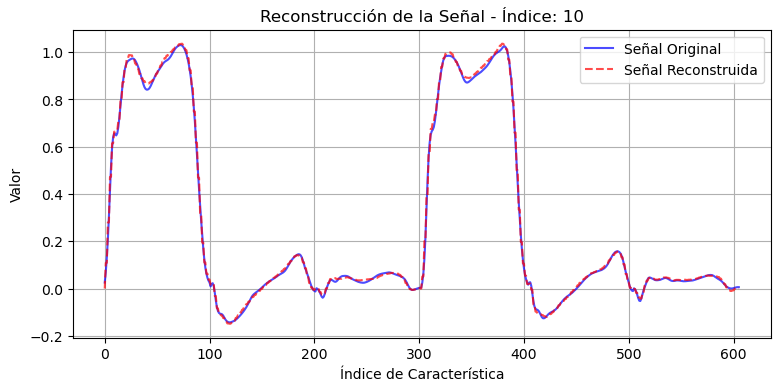

In [22]:
# Seleccionar una señal para visualizar
indice_señal = 10  # Cambia este índice para visualizar otras señales

# Llamar a la función de visualización
visualizar_reconstruccion(autoencoder, X_train_ae, indice_señal)

## Visualizacion de espacios

### Espacio original 

In [23]:
"""
# Aplicar t-SNE directamente al conjunto original X_train
tsne_original = TSNE(n_components=2, random_state=42)
X_train_2D = tsne_original.fit_transform(X_train_ae)

# Mostrar las dimensiones resultantes
print("Dimensiones originales:", X_train_ae.shape)
print("Dimensiones después de t-SNE:", X_train_2D.shape)
"""

'\n# Aplicar t-SNE directamente al conjunto original X_train\ntsne_original = TSNE(n_components=2, random_state=42)\nX_train_2D = tsne_original.fit_transform(X_train_ae)\n\n# Mostrar las dimensiones resultantes\nprint("Dimensiones originales:", X_train_ae.shape)\nprint("Dimensiones después de t-SNE:", X_train_2D.shape)\n'

In [24]:
"""
# Visualizar el conjunto original utilizando un scatter plot
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0, 1]):
    indices = Y_train_ae == clase
    plt.scatter(
        X_train_2D[indices, 0], 
        X_train_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.5,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Conjunto X_train (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()
"""


'\n# Visualizar el conjunto original utilizando un scatter plot\nplt.figure(figsize=(9, 6))\ncolores = [\'royalblue\', \'darkorange\']  # Colores para las clases\n\nfor i, clase in enumerate([0, 1]):\n    indices = Y_train_ae == clase\n    plt.scatter(\n        X_train_2D[indices, 0], \n        X_train_2D[indices, 1], \n        label=f\'Clase {clase}\',\n        alpha=0.5,  # Transparencia para observar superposición\n        c=colores[i],\n        edgecolor=\'w\',  # Borde blanco para mayor claridad\n        linewidth=0.5,\n        s=30  # Tamaño de los puntos\n    )\n\n# Configuración del gráfico\nplt.title("Conjunto X_train (t-SNE)", fontsize=16, pad=15)\nplt.xlabel("Componente 1", fontsize=12)\nplt.ylabel("Componente 2", fontsize=12)\nplt.legend(fontsize=12, loc=\'upper right\')\nplt.grid(visible=True, linestyle=\'--\', alpha=0.5)  # Agregar una cuadrícula suave\nplt.tight_layout()\nplt.show()\n'

### Espacio latente

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Crear el encoder como modelo independiente usando el nombre de la capa
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_2').output)
#encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[6].output)  


# Generar el espacio latente utilizando el encoder
espacio_latente = encoder.predict(X_train_ae)

# Verificar las dimensiones del espacio latente
print(f"Dimensiones de X_train_ae: {X_train_ae.shape}")
print(f"Dimensiones del espacio latente: {espacio_latente.shape}")

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Dimensiones de X_train_ae: (12408, 606)
Dimensiones del espacio latente: (12408, 100)


In [27]:
# Guardar el encoder
encoder.save("../Modelos/Binary_Encoder_CNN.keras")
print("Encoder guardado exitosamente.")

Encoder guardado exitosamente.


In [28]:
# Reducir el espacio latente a 2 dimensiones usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
espacio_latente_2D = tsne.fit_transform(espacio_latente)

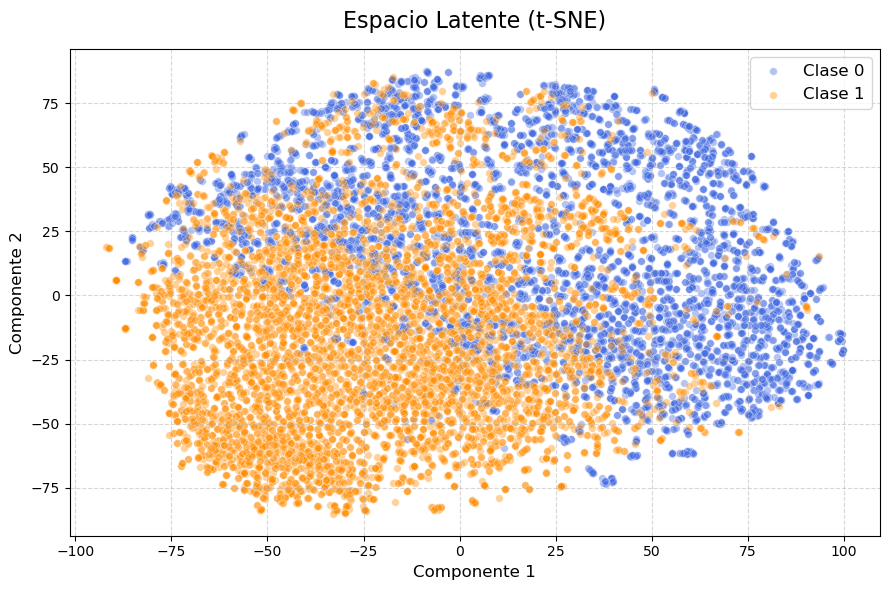

In [30]:
# Visualizar el espacio latente utilizando un scatter plot con mejoras
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0, 1]):
    indices = Y_train_ae == clase
    plt.scatter(
        espacio_latente_2D[indices, 0], 
        espacio_latente_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.4,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()